In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import copy
from models import MLP
from get_embedded_data import get_data_tokenizer_MLP, split_data, MAPPING


c:\Users\kwarc\PycharmProjects\NLP\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\kwarc\PycharmProjects\NLP\.venv\Lib\site-packages\torchtext\vocab\__init__.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)
c:\Users\kwarc\PycharmProjects\NLP\.venv\Lib\site-packages\torchtext\utils.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginn

In [2]:
device = torch.device("cuda")
device

device(type='cuda')

In [3]:
from transformers import BertModel, ElectraModel, RobertaModel
from transformers import BertTokenizer, ElectraTokenizer, RobertaTokenizer


bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = BertModel.from_pretrained('bert-base-uncased')

robert_tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
robert_model = RobertaModel.from_pretrained('roberta-base')

electra_tokenizer = ElectraTokenizer.from_pretrained('google/electra-small-discriminator')
electra_model = ElectraModel.from_pretrained('google/electra-small-discriminator')

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [4]:
# tokenizer = bert_tokenizer
# model = bert_model

tokenizer = robert_tokenizer
model = robert_model

# tokenizer = electra_tokenizer
# model = electra_model

In [5]:
X_train, X_test, y_train, y_test = split_data("data_set.csv", "author", "quote", test_size=0.2, separator="@", mapping=MAPPING, labels_to_delete=["hegel", "plato", "spinoza"])

['aristotle' 'freud' 'hegel' 'kant' 'nietzsche' 'plato' 'sartre'
 'schopenhauer' 'spinoza']


In [6]:
train_dataloader, shape = get_data_tokenizer_MLP(batch=20, words=X_train, labels=y_train, device=device, tokenizer=tokenizer, model=model)
test_dataloader, shape = get_data_tokenizer_MLP(batch=20, words=X_test, labels=y_test, device=device, tokenizer=tokenizer, model=model)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
c:\Users\kwarc\PycharmProjects\NLP\.venv\Lib\site-packages\transformers\tokenization_utils_base.py:2688: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [7]:
network = MLP(shape*125, 125*2, 125, 9).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(network.parameters())

Test accuracy: 33.80952380952381
[1/20] loss: 0.074 accuracy: 29
Test accuracy: 37.142857142857146
[2/20] loss: 0.052 accuracy: 54
Test accuracy: 39.76190476190476
[3/20] loss: 0.038 accuracy: 66
Test accuracy: 36.42857142857143
[4/20] loss: 0.026 accuracy: 78
Test accuracy: 41.666666666666664
[5/20] loss: 0.018 accuracy: 85
Test accuracy: 41.904761904761905
[6/20] loss: 0.015 accuracy: 87
Test accuracy: 38.80952380952381
[7/20] loss: 0.011 accuracy: 90
Test accuracy: 41.904761904761905
[8/20] loss: 0.006 accuracy: 95
Test accuracy: 39.523809523809526
[9/20] loss: 0.003 accuracy: 98
Test accuracy: 42.857142857142854
[10/20] loss: 0.003 accuracy: 98
Test accuracy: 38.57142857142857
[11/20] loss: 0.002 accuracy: 98
Test accuracy: 36.666666666666664
[12/20] loss: 0.010 accuracy: 91
Test accuracy: 39.76190476190476
[13/20] loss: 0.004 accuracy: 96
Test accuracy: 37.38095238095238
[14/20] loss: 0.006 accuracy: 95
Test accuracy: 40.95238095238095
[15/20] loss: 0.004 accuracy: 96
Test accurac

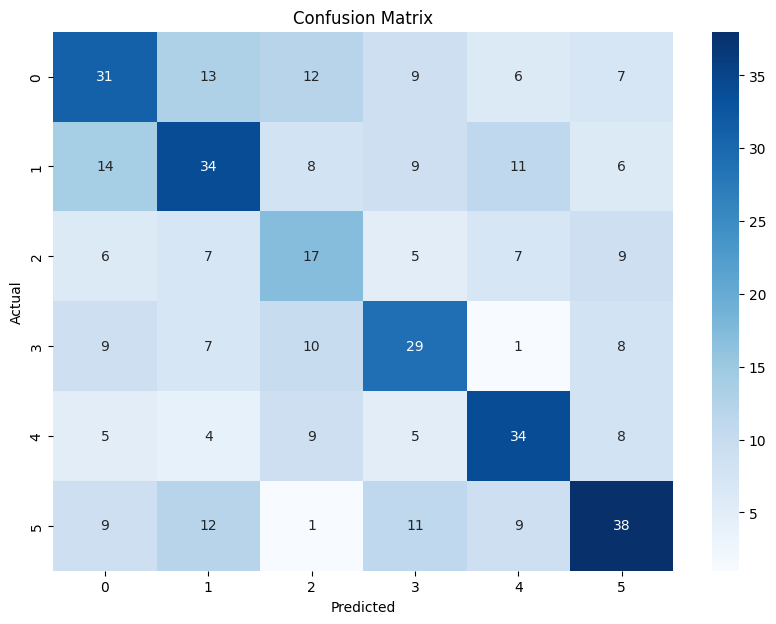

In [8]:
max_epoch = 20
network.train()
best_network = network
best_accuracy = 0
for epoch in range(max_epoch):

    running_loss = 0.0
    correct = 0
    total = 0
    for i, data in enumerate(train_dataloader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        inputs = torch.flatten(inputs.double(), 1)
        outputs = network(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()


        total += labels.size(0)
        _, predicted = torch.max(outputs.data, 1)
        correct += (predicted == labels).sum().item()

        running_loss += loss.item()


    val_correct = 0
    val_total = 0
    for i, val_data in enumerate(test_dataloader, 0):
        val_inputs, val_labels = val_data
        val_inputs, val_labels = val_inputs.to(device), val_labels.to(device)

        val_inputs = torch.flatten(val_inputs.double(), 1)
        val_outputs = network(val_inputs)

        val_total += val_labels.size(0)
        _, val_predicted = torch.max(val_outputs.data, 1)
        val_correct += (val_predicted == val_labels).sum().item()
    if 100 * val_correct / val_total > best_accuracy:
        best_network = copy.deepcopy(network)
    print(f"Test accuracy: {100 * val_correct / val_total}")


    print('[%d/%d] loss: %.3f accuracy: %d' %
          (epoch+1, max_epoch, running_loss / 2000, 100 * correct / total))
    running_loss = 0.0

print('Finished Training')

correct = 0
total = 0
all_labels = []
all_predictions = []
for i, data in enumerate(test_dataloader, 0):
    inputs, labels = data
    inputs, labels = inputs.to(device), labels.to(device)

    inputs = torch.flatten(inputs.double(), 1)
    outputs = best_network(inputs)


    total += labels.size(0)
    _, predicted = torch.max(outputs.data, 1)
    correct += (predicted == labels).sum().item()

    all_labels.extend(labels.cpu().numpy())
    all_predictions.extend(predicted.cpu().numpy())

print(f"Test accuracy: {100 * correct / total}")

cm = confusion_matrix(all_labels, all_predictions)

plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()
